In [1]:
import tensorflow as tf
import keras 
import matplotlib.pyplot as plt

In [2]:
(X_train, Y_train),(X_test,Y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
X_train.shape, Y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [4]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
validation_images, validation_labels = X_train[:5000],Y_train[:5000]
train_images,train_labels = X_train[5000:], Y_train[5000:]
validation_images.shape,validation_labels.shape,train_images.shape,train_labels.shape

((5000, 32, 32, 3), (5000, 1), (45000, 32, 32, 3), (45000, 1))

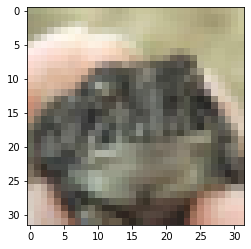

In [6]:
plt.imshow(X_train[25])

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [8]:
print(validation_ds)

<TensorSliceDataset shapes: ((32, 32, 3), (1,)), types: (tf.uint8, tf.uint8)>


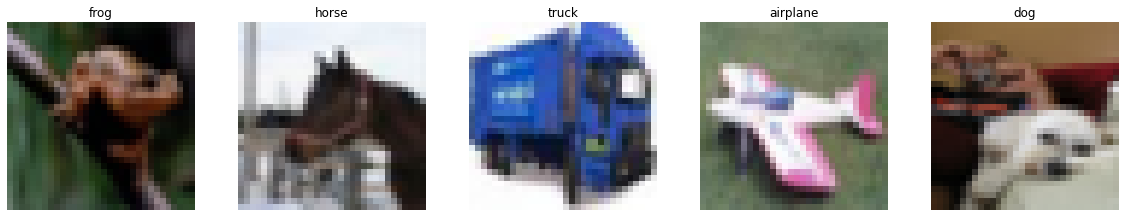

In [9]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

In [10]:
def augment_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

In [11]:
print(train_ds)

<TensorSliceDataset shapes: ((32, 32, 3), (1,)), types: (tf.uint8, tf.uint8)>


In [12]:
train_ds_size = len(list(train_ds))
train_ds_size = len(list(test_ds))
validation_ds_size = len(list(validation_ds))

In [13]:
train_ds = (train_ds
                  .map(augment_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

test_ds = (test_ds
                  .map(augment_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

validation_ds = (validation_ds
                  .map(augment_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))



In [14]:
print(validation_ds)

<BatchDataset shapes: ((32, 227, 227, 3), (32, 1)), types: (tf.float32, tf.uint8)>


In [36]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout


In [37]:
model = Sequential()

In [38]:
model.add(Conv2D(input_shape=(227,227,3),filters=96,kernel_size=(11,11),strides=4,activation="relu"))

In [39]:
model.add(BatchNormalization())

In [40]:
model.add(MaxPool2D(pool_size=(3,3), strides=2))

In [41]:
model.add(Conv2D(filters=256,kernel_size=(11,11),strides=1,padding="same"))

In [42]:
model.add(BatchNormalization())

In [43]:
model.add(MaxPool2D(pool_size=(3,3), strides=2))

In [44]:
model.add(Conv2D(filters=384,kernel_size=(3,3), strides=1,padding="same"))

In [45]:
model.add(BatchNormalization())

In [46]:
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=1,padding="same"))

In [47]:
model.add(BatchNormalization())

In [48]:
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=1,padding="same"))

In [49]:
model.add(BatchNormalization())

In [50]:
model.add(MaxPool2D(pool_size=(3,3), strides=2))

In [51]:
model.add(Flatten())

In [52]:
model.add(Dense(4096,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4096,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10,activation="softmax"))

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 256)       2973952   
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 384)      

In [54]:
import os, time

In [55]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [56]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.fit(train_ds,
          epochs=50,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

Epoch 1/50
   4/1406 [..............................] - ETA: 4:19:52 - loss: 3.9174 - accuracy: 0.1191

In [ ]:
model.evaluate(test_ds)

312/312 [==============================] - 11s 26ms/step - loss: 1.9446 - accuracy: 0.1847


[1.944624662399292, 0.1846955120563507]